In [3]:
from pathlib import Path
import urllib.request

data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)

url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
dest = data_dir / 'train.csv'
if not dest.exists():
    print('Downloading dataset...')
    urllib.request.urlretrieve(url, dest)
else:
    print('Dataset already exists:', dest)
print('Saved to', dest)


Saved to ..\data\train.csv


In [4]:
import pandas as pd
df=pd.read_csv("../data/train.csv")
df.head()
df.shape
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


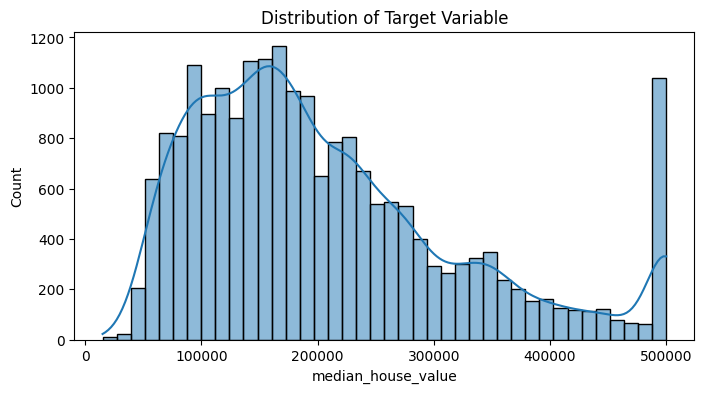

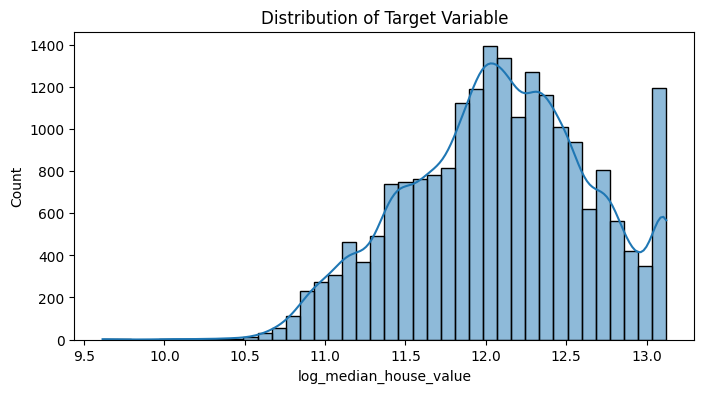

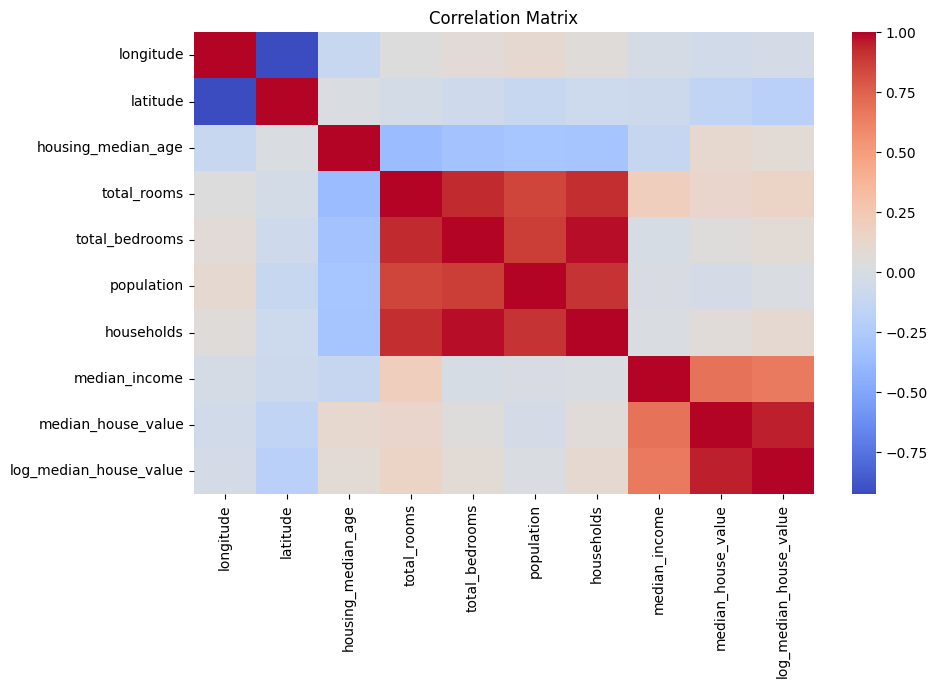

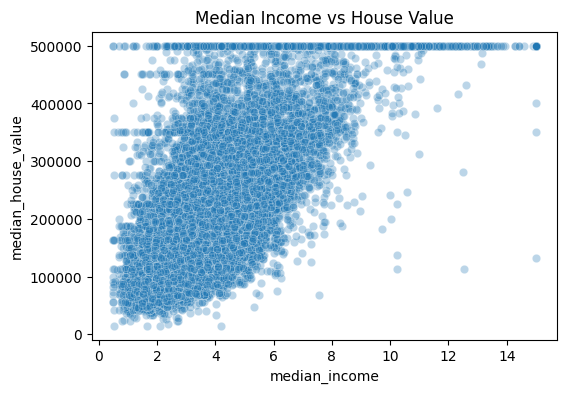

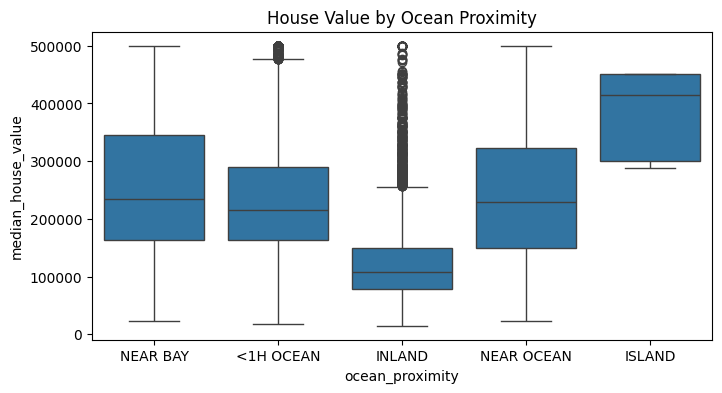

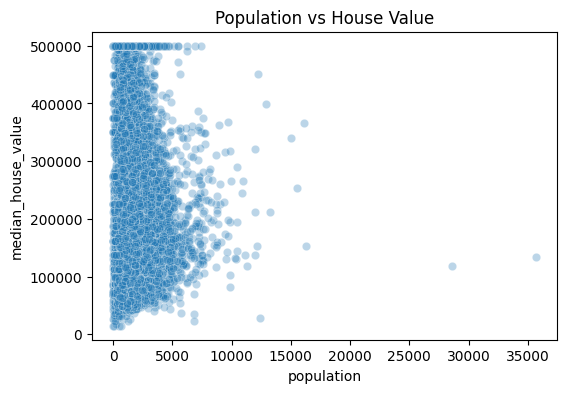

In [5]:
#Distribution of Target variable
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,4))
sns.histplot(df['median_house_value'],bins=40,kde=True)
plt.title('Distribution of Target Variable')
plt.show()

#Log Transform
import numpy as np
df['log_median_house_value']=np.log1p(df['median_house_value'])
plt.figure(figsize=(8,4))
sns.histplot(df['log_median_house_value'],bins=40,kde=True)
plt.title('Distribution of Target Variable')
plt.show()

#correlation with target
plt.figure(figsize=(10,6))
corr=df.corr(numeric_only=True)
sns.heatmap(corr,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#median income vs House Value
plt.figure(figsize=(6,4))
sns.scatterplot(
    x='median_income',
    y='median_house_value',
    data=df,
    alpha=0.3
)
plt.title('Median Income vs House Value')
plt.show()

#ocean proximity vs House value
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df,
    x='ocean_proximity',
    y='median_house_value'
)
plt.title("House Value by Ocean Proximity")
plt.show()

#Population & household effect
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x='population',
    y='median_house_value',
    alpha=0.3
)
plt.title("Population vs House Value")
plt.show()



In [6]:
#missing value
#only 207 values are there so best way is using
#median Imputation
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
df['total_bedrooms']=imputer.fit_transform(df[['total_bedrooms']])
df.isnull().sum()


longitude                 0
latitude                  0
housing_median_age        0
total_rooms               0
total_bedrooms            0
population                0
households                0
median_income             0
median_house_value        0
ocean_proximity           0
log_median_house_value    0
dtype: int64

In [7]:
# feature engineering
df['rooms_per_household']=df['total_rooms']/df['households']
df['bedrooms_per_room']=df['total_bedrooms']/df['total_rooms']
df['population_per_household']=df['population']/df['households']
df[['rooms_per_household','bedrooms_per_room',
    'population_per_household']].head()


,rooms_per_household,bedrooms_per_room,population_per_household
0,6.984127,0.146591,2.555556
1,6.238137,0.155797,2.109842
2,8.288136,0.129516,2.802260
3,5.817352,0.184458,2.547945
4,6.281853,0.172096,2.181467


In [8]:
import numpy as np
x=df.drop(columns=['median_house_value','log_median_house_value'])
y=df['median_house_value']

# Drop the misspelled column if it exists in x
if 'bedrroms_per_room' in x.columns:
    x = x.drop(columns=['bedrroms_per_room'])

# Automatically identify numerical and categorical features based on data types
num_features = x.select_dtypes(include=np.number).columns.tolist()
cat_features = x.select_dtypes(include='object').columns.tolist()

num_features,cat_features

(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'rooms_per_household',
  'bedrooms_per_room',
  'population_per_household'],
 ['ocean_proximity'])

In [9]:
#pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline=Pipeline([
    ('scaler',StandardScaler())
])

cat_pipeline=Pipeline([
    ('onehot',OneHotEncoder())
])

preprocessor=ColumnTransformer([
    ('num',num_pipeline,num_features),
    ('cat',cat_pipeline,cat_features)
])

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
from sklearn.metrics import mean_squared_error
def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))


In [11]:
from sklearn.linear_model import LinearRegression
lin_reg=Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression())
])
lin_reg.fit(x_train,y_train)
y_pred=lin_reg.predict(x_test)
print(rmse(y_test,y_pred))

#RANDOMFOREST
from sklearn.ensemble import RandomForestRegressor
rf_reg=Pipeline([
    ('preprocessor',preprocessor),
    ('RF',RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])
rf_reg.fit(x_train,y_train)
y_pred=rf_reg.predict(x_test)
print(rmse(y_test,y_pred))

#GRADIENTBOOSTING
from sklearn.ensemble import GradientBoostingRegressor
gb_reg=Pipeline([
    ('preprocessor',preprocessor),
    ('GBOOST',GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb_reg.fit(x_train,y_train)
y_pred=gb_reg.predict(x_test)
print(rmse(y_test,y_pred))

72668.53837868225
50063.35778843552
53918.85558492296


In [12]:
from sklearn.model_selection import GridSearchCV
param_grid={
    'RF__n_estimators':[100,200,300],
    'RF__max_depth':[None, 10, 20],
    'RF__min_samples_split':[2,5]
}

rf_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('RF',RandomForestRegressor(random_state=42, n_jobs=-1))
])
grid_search=GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(x_train,y_train)
print(grid_search.best_params_)
print(-grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'RF__max_depth': None, 'RF__min_samples_split': 2, 'RF__n_estimators': 300}
2564758635.76165


In [13]:
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(x_test)
print("Tuned Random Forest RMSE:", rmse(y_test, y_pred_best))


Tuned Random Forest RMSE: 50015.13159792915


In [14]:
# Get numerical feature names
num_features_out = num_features

# Get categorical feature names after one-hot encoding
cat_encoder = best_model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot']

cat_features_out = cat_encoder.get_feature_names_out(cat_features)

# Combine all feature names
feature_names = list(num_features_out) + list(cat_features_out)


In [15]:
import numpy as np
import pandas as pd

importances = best_model.named_steps['RF'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(10)


,feature,importance
7,median_income,0.480859
12,ocean_proximity_INLAND,0.138620
10,population_per_household,0.120942
0,longitude,0.057775
1,latitude,0.056684
2,housing_median_age,0.044080
8,rooms_per_household,0.026080
9,bedrooms_per_room,0.024374
3,total_rooms,0.012639
4,total_bedrooms,0.011951


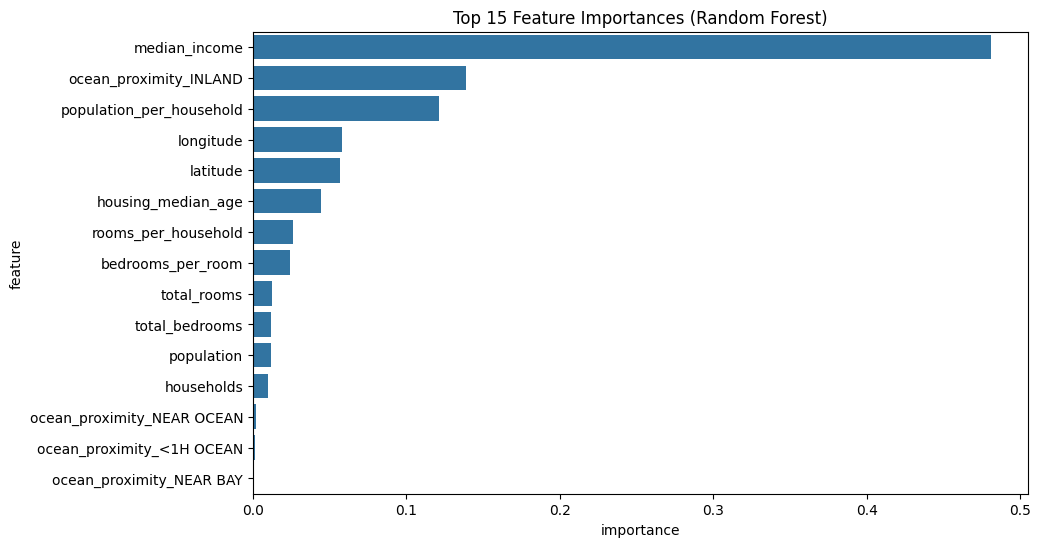

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = feature_importance_df.head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [28]:
import joblib
import os

# Ensure models directory exists
os.makedirs("models", exist_ok=True)

# Save the trained model
joblib.dump(lin_reg, "models/house_price_model.pkl")

print("✅ Model saved successfully at models/house_price_model.pkl")


✅ Model saved successfully at models/house_price_model.pkl


In [29]:
loaded_model = joblib.load("models\house_price_model.pkl")

sample_pred = loaded_model.predict(x_test[:5])
sample_pred


array([ 61463.74466641, 121631.21809998, 267594.25389058, 264252.9638203 ,
       258213.78982811])